# Sumarizador abstrato de texto
Nesse notebook serão feitos o passo-a-passo para a implementação de um sumarizador de texto através se uma rede neural RNN LSTM consituida de um encoder e um decoder com um sistema de atenção implementado nas hidden layers.


O primeiro passo será importar todas as bibliotecas necessárias e fazer a analise e limpesa do dataset

In [0]:
# Importando as bibliotecas de manipulação e exploração de dados
import numpy as np
import os
import pandas as pd
import spacy
import re
import nltk
from nltk.corpus import stopwords
pd.set_option("display.max_colwidth", 500)

In [2]:
from google.colab import files, drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
src = list(files.upload().values())[0]

Saving attention.py to attention.py


In [4]:
open('mylib.py','wb').write(src)

5230

In [5]:
#importando a biblioteca da layer de atenção que não se encontra no keras
from attention import AttentionLayer

In [6]:
#importando as bibliotecas de DeepLearning
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
# Abrindo o dataset em um arquivo pandas
df = pd.read_csv('/content/drive/My Drive/TCC/Dados/tcu_acordaos2.csv')

In [0]:
# Eliminando duplicatcas e arquivos em branco
df = df[['sumario','acordao']]
df.drop_duplicates(subset=['acordao'],inplace=True)
df.dropna(axis=0,inplace=True)

In [9]:
df.acordao[0]

'Vistos, relatados e discutidos estes autos de Tomada de Contas Especial de responsabilidade de Orlando Rosa de Moura em decorrência da omissão no dever de prestar contas dos recursos repassados à Prefeitura Municipal de Roseira/SP mediante o Convênio nº 92/95, celebrado com o extinto Ministério do Planejamento e Orçamento em 28/12/95, no valor total de R$ 240.000,00, do qual R$ 200.00,000 correspondem à participação da União, sendo o restante a cargo do Município, objetivando a canalização dos córregos Divisa, Pedro Galvão, Roseira Velha e Santa Cruz, no total de 645 metros.  Considerando que, regularmente citado, e decorrido o prazo estipulado, o responsável não recolheu a importância devida nem apresentou alegações de defesa, como foi-lhe facultado, caracterizando-se, assim, a revelia;  Considerando que o valor do débito é superior àquele fixado na IN/TCU nº 14/96 para organização do processo de cobrança executiva (1.500 UFIR); e  Considerando os pareceres coincidentes da Unidade Té

## Nós vamos performar os seguintes pré-processamentos nos nossos dados:

1.Converter tudo para caixa baixa

4.Remover (‘s)

5.Remover texto de dentro de parenteses ()

6.Eliminar pontuação e caracteres especiais

7.Remover stopwords

8.Remover palavras curtas

Definiremos a nossa função como:

In [10]:
df.sumario[0]

'Tomada de Contas Especial. Omissão no dever de prestar contas de  recursos repassados à Municipalidade mediante convênio celebrado com o  extinto Ministério do Planejamento e Orçamento. Responsável revel.  Contas irregulares. Débito. Autorização para cobrança judicial da  dívida.'

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
def texto_limpo(text, sumario=False):
  if not sumario:
    # Convertendo para lower case
    text_limpo = text.lower()
    # Eliminando caracteres especiais
    text_limpo = re.sub(r'[_"\-;%()¿|+º&=*%!.,:#$@\[\]/]', ' ', text_limpo)
    # Eliminando espaços duplos
    text_limpo = re.sub(r'\s\s', ' ', text_limpo)
    # Eliminando números
    text_limpo = re.sub(r'[0-9]', '', text_limpo)
    # Eliminando palavras pequenas
    tokens = text_limpo.split()
    palavras_grandes=[]
    for i in tokens:
      if len(i)>=3:
        palavras_grandes.append(i)  

    text_limpo = " ".join(palavras_grandes)

    text_limpo = text_limpo.split()
    stops = set(stopwords.words("portuguese"))
    text_limpo = [w for w in text_limpo if not w in stops]
    text_limpo = " ".join(text_limpo)

  if sumario:
    # Convertendo para lower case
    text_limpo = text.lower()
    # Eliminando caracteres especiais
    text_limpo = re.sub(r'[_"\-;%()¿|+º&=*%!,:#$@\[\]/]', ' ', text_limpo)
    # Tornando ponto  em tokens
    text_limpo = re.sub(r'\.', ' .', text_limpo)
    # Eliminando espaços duplos
    text_limpo = re.sub(r'\s\s+', ' ', text_limpo)
    # Eliminando números
    text_limpo = re.sub(r'[0-9]', '', text_limpo)
    # Eliminando palavras pequenas
    tokens = text_limpo.split()
    palavras_grandes=[]
    for i in tokens:
      if len(i)>1:
        palavras_grandes.append(i)

  return text_limpo

In [0]:
#limpando os acordaos
acordao_limpo = []
for t in df['acordao']:
   acordao_limpo.append(texto_limpo(t,sumario = False))

In [14]:
acordao_limpo[0] 

'vistos relatados discutidos autos tomada contas especial responsabilidade orlando rosa moura decorrência omissão dever prestar contas recursos repassados prefeitura municipal roseira mediante convênio celebrado extinto ministério planejamento orçamento valor total correspondem participação união sendo restante cargo município objetivando canalização córregos divisa pedro galvão roseira velha santa cruz total metros considerando regularmente citado decorrido prazo estipulado responsável recolheu importância devida apresentou alegações defesa facultado caracterizando assim revelia considerando valor débito superior àquele fixado tcu organização processo cobrança executiva ufir considerando pareceres coincidentes unidade técnica ministério público irregularidade presentes contas acordam ministros tribunal contas união reunidos sessão câmara fundamento arts iii alínea iii alínea lei julgar presentes contas irregulares condenar orlando rosa moura pagamento quantia duzentos mil reais fixaçã

In [0]:
#Limapando os sumarios
sumario_limpo = []
for t in df['sumario']:
    sumario_limpo.append(texto_limpo(t, sumario = True))

In [16]:
sumario_limpo[0]

'tomada de contas especial . omissão no dever de prestar contas de recursos repassados à municipalidade mediante convênio celebrado com o extinto ministério do planejamento e orçamento . responsável revel . contas irregulares . débito . autorização para cobrança judicial da dívida .'

In [0]:
df['acordao']=acordao_limpo
df['sumario']=sumario_limpo

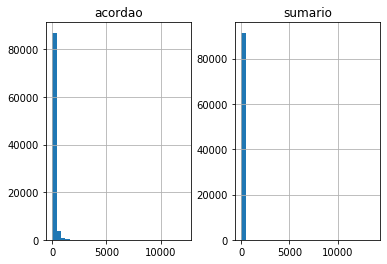

In [18]:
import matplotlib.pyplot as plt

acordao_word_count = []
sumario_word_count = []

# Criando listas com as lengths dos textos
for i in df['acordao']:
      acordao_word_count.append(len(i.split()))

for i in df['sumario']:
      sumario_word_count.append(len(i.split()))

length_df = pd.DataFrame({'acordao':acordao_word_count, 'sumario':sumario_word_count})

length_df.hist(bins = 30)
# # plt.xlim([-3, 500])
# # plt.ylim([-3, 10000])
# plt.yticks(np.arange(0, 100000, 20000))
# plt.xticks(np.arange(0, 1000, 100))
plt.show()

In [19]:
#Definindo o tamanho maximo dos sumarios
cnt=0
for i in df.sumario:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(df.sumario))

0.8720710485782638


In [20]:
# Definindo o tamanho máximo dos acordãos
cnt=0
for i in df.acordao:
    if(len(i.split())<=300):
        cnt=cnt+1
print(cnt/len(df.acordao))

0.8917667107261068


In [0]:
#Definindo os valores finais
max_len_text=300
max_len_summary=100

In [0]:
#Eliminando os textos muito grandes
cleaned_acordao =np.array(df.acordao)
cleaned_sumario=np.array(df.sumario)

short_acordao=[]
short_sumario=[]

for i in range(len(cleaned_acordao)):
    if(len(cleaned_sumario[i].split())<=max_len_summary and len(cleaned_acordao[i].split())<=max_len_text):
        short_acordao.append(cleaned_acordao[i])
        short_sumario.append(cleaned_sumario[i])
        
df=pd.DataFrame({'acordao':short_acordao,'sumario':short_sumario})

In [0]:
# Incluindo os tokens de inicio e final de sentença
df['sumario'] = df['sumario'].apply(lambda x : 'xxbos '+ x + ' xxeos')

In [24]:
for i in range(5):
    print("Acordão:",df['acordao'][i])
    print("Sumario:",df['sumario'][i])
    print("\n")

Acordão: vistos relatados discutidos autos tomada contas especial responsabilidade orlando rosa moura decorrência omissão dever prestar contas recursos repassados prefeitura municipal roseira mediante convênio celebrado extinto ministério planejamento orçamento valor total correspondem participação união sendo restante cargo município objetivando canalização córregos divisa pedro galvão roseira velha santa cruz total metros considerando regularmente citado decorrido prazo estipulado responsável recolheu importância devida apresentou alegações defesa facultado caracterizando assim revelia considerando valor débito superior àquele fixado tcu organização processo cobrança executiva ufir considerando pareceres coincidentes unidade técnica ministério público irregularidade presentes contas acordam ministros tribunal contas união reunidos sessão câmara fundamento arts iii alínea iii alínea lei julgar presentes contas irregulares condenar orlando rosa moura pagamento quantia duzentos mil reai

In [0]:
# Dividindo em test e validação
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['acordao']),np.array(df['sumario']),test_size=0.2,random_state=3,shuffle=True) 

In [0]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#Prepare o tokenizador dos acordãos
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

#Converter texto em sequencia de números
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#Fazendo padding para o length máximo
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [0]:
#Prepare o tokenizador dos sumarios
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#Converter texto em sequencia de números
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#Fazendo padding para o length máximo
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [0]:
# Dicionarios trazendo de volta index para palavra
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [0]:
from keras import backend as K 
K.clear_session() 
latent_dim = 256

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

#------------------------------------------------------------------------------#

# Inicializando o decoder 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM usando encoder_states como estados iniciais
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Layer de Atenção
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

#Concatenar a saida da layer de atenção com a saida do decoder
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Layer de probabilidade distribuida no vocabulario
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define o modelo
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

# Carregando os pesos previamente treinados
# model.load_weights('/content/drive/My Drive/TCC/modelos/epochs:012-val_acc:0.812.hdf5')

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [0]:
filepath = '/content/drive/My Drive/TCC/modelos/modelo1:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5'
mc = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', save_freq='epoch')

In [34]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=12,callbacks=[es,mc],batch_size=80, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 57725 samples, validate on 14432 samples
Epoch 1/12
57725/57725 [==============================] - 2653s 46ms/sample - loss: 1.9936 - acc: 0.6823 - val_loss: 1.4634 - val_acc: 0.7430
Epoch 2/12
57725/57725 [==============================] - 2629s 46ms/sample - loss: 1.3487 - acc: 0.7587 - val_loss: 1.2518 - val_acc: 0.7712
Epoch 3/12
57725/57725 [==============================] - 2613s 45ms/sample - loss: 1.1948 - acc: 0.7788 - val_loss: 1.1583 - val_acc: 0.7834
Epoch 4/12
57725/57725 [==============================] - 2609s 45ms/sample - loss: 1.1104 - acc: 0.7905 - val_loss: 1.1085 - val_acc: 0.7911
Epoch 5/12
57725/57725 [==============================] - 2618s 45ms/sample - loss: 1.0530 - acc: 0.7986 - val_loss: 1.0713 - val_acc: 0.7969
Epoch 6/12
57725/57725 [==============================] - 2622s 45ms/sample - loss: 1.0106 - acc: 0.8050 - val_loss: 1.0494 - val_acc: 0.8007
Epoc

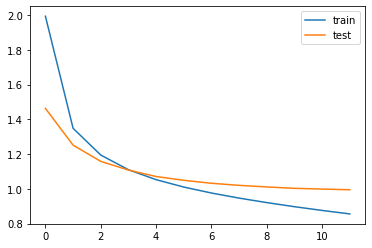

In [35]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()